In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data_dir = os.path.join("../../data/embeddings/")

### Get data

In [2]:
mean_embeddings = pd.read_pickle(data_dir +"embedding_summaries/mean_embeddings_per_lsoa.pkl")

imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

mean_embeddings_with_imd = pd.merge(left=mean_embeddings, right=imd, on="LSOA21CD")


X = np.stack(mean_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = mean_embeddings_with_imd['imd_rank'].values

### Compare correlations between each embedding dimension and IMD and a randomly generated embedding

In [3]:
n_samples, n_dims = X.shape  # X = your real embeddings
np.random.seed(41)

# Generate random embeddings: same shape, e.g., uniform or normal
X_random = np.random.randn(n_samples, n_dims)

Max absolute correlation in random embeddings: 0.088
Max absolute correlation in real embeddings: 0.508


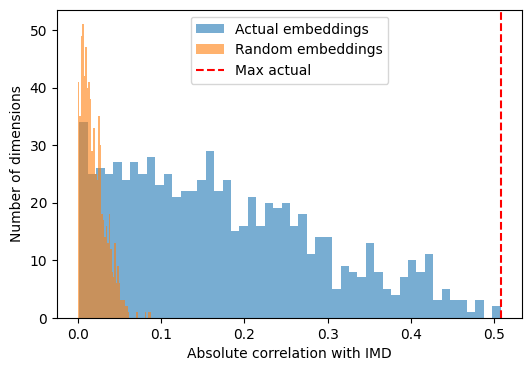

In [4]:
# Correlation per dimension for random embeddings
corrs_random = [np.corrcoef(X_random[:, i], y)[0, 1] for i in range(n_dims)]
corrs_random = np.array(corrs_random)

# Get max absolute correlation among all random dimensions
max_random_corr = np.max(np.abs(corrs_random))
print(f"Max absolute correlation in random embeddings: {max_random_corr:.3f}")

corrs_actual = [np.corrcoef(X[:, i], y)[0, 1] for i in range(n_dims)]
corrs_actual = np.array(corrs_actual)
max_actual_corr = np.max(np.abs(corrs_actual))
print(f"Max absolute correlation in real embeddings: {max_actual_corr:.3f}")

plt.figure(figsize=(6,4))
plt.hist(np.abs(corrs_actual), bins=50, alpha=0.6, label="Actual embeddings")
plt.hist(np.abs(corrs_random), bins=50, alpha=0.6, label="Random embeddings")
plt.axvline(max_actual_corr, color='red', linestyle='--', label='Max actual')
plt.xlabel("Absolute correlation with IMD")
plt.ylabel("Number of dimensions")
plt.legend()
plt.show()

### Plot the correlation scatter for the most correlated dimension

Most correlated embedding dimension: 31, correlation = -0.51


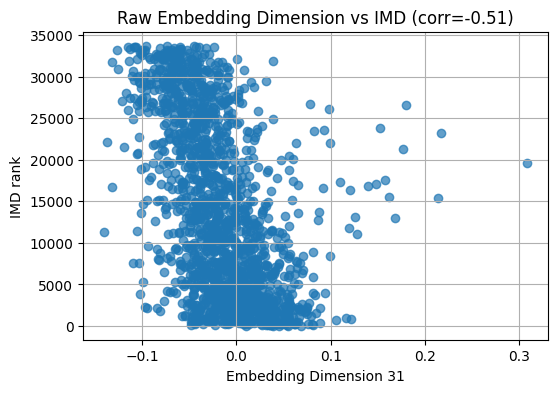

In [5]:
X = np.stack(mean_embeddings_with_imd["mean_embedding"].values)
y = mean_embeddings_with_imd["imd_rank"].values

# Compute correlation of each dimension with IMD
corrs = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
corrs = np.array(corrs)

# Find top correlated dimension
top_dim = np.argmax(np.abs(corrs))
print(f"Most correlated embedding dimension: {top_dim}, correlation = {corrs[top_dim]:.2f}")

plt.figure(figsize=(6,4))
plt.scatter(X[:, top_dim], y, alpha=0.7)
plt.xlabel(f"Embedding Dimension {top_dim}")
plt.ylabel("IMD rank")
plt.title(f"Raw Embedding Dimension vs IMD (corr={corrs[top_dim]:.2f})")
plt.grid(True)
plt.show()

### Run a PCA to produce 2 PCs and plot against each other, coloured by IMD rank

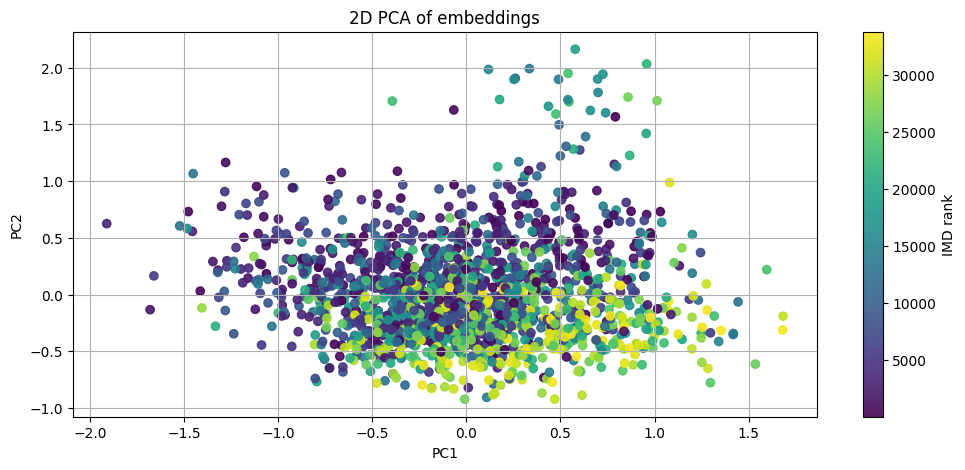

Correlation with PC1: 0.25
Correlation with PC2: -0.35


In [9]:
pca = PCA(n_components=2)  # keep 95% variance
X_pca = pca.fit_transform(X)
y = mean_embeddings_with_imd["imd_rank"].values

plt.figure(figsize=(12,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.9)
plt.colorbar(label="IMD rank")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of embeddings")
plt.grid(True)
plt.show()

corr_pc1 = np.corrcoef(X_pca[:,0], y)[0,1]
corr_pc2 = np.corrcoef(X_pca[:,1], y)[0,1]

print(f"Correlation with PC1: {corr_pc1:.2f}")
print(f"Correlation with PC2: {corr_pc2:.2f}")